In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np
import numpy.random
import xarray as xa

# Generate some data:

In [2]:
from batchglm.api.models.glm_nb import Simulator

sim = Simulator(num_observations=2000, num_features=1000)
sim.generate_sample_description(num_batches=0, num_conditions=2)
sim.generate_params()
sim.generate_data()

X = sim.X
sample_description = sim.sample_description

Superimpose library size effects on counts:

In [3]:
size_factors = numpy.random.normal(loc=1, scale=0.1, size=X.shape[0]) # draw random factors
size_factors[size_factors < 0.2] = 0.2 # threshold
X = np.round(X*np.repeat(np.expand_dims(size_factors, axis=1), axis=1, repeats=X.shape[1])) # scale counts and round

Check size factor scaling:

In [4]:
np.mean(np.sum(X, axis=1).values/np.mean(np.sum(X, axis=1)).values - size_factors)

-0.0011060609572317503

# Run differential expression test:

## With size factor correction

In [5]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.wald(
    data=X,
    formula="~ 1 + condition",
    factor_loc_totest="condition",
    sample_description=sample_description,
    size_factors=size_factors,
    batch_size=100,
    training_strategy="DEFAULT",
    dtype="float64"
)


INFO:diffxpy.testing.base:Fitting model...


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Obtaining the results

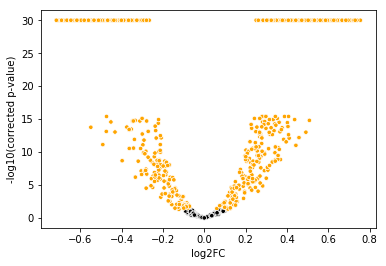

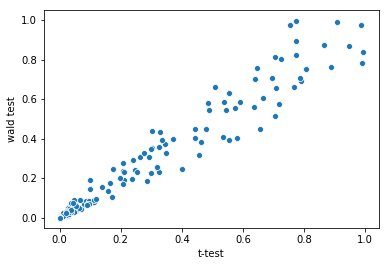

In [6]:
test.plot_diagnostics()

## Without size factor correction

In [7]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.wald(
    data=X,
    formula="~ 1 + condition",
    factor_loc_totest="condition",
    sample_description=sample_description,
    batch_size=100,
    training_strategy="DEFAULT",
    dtype="float64"
)


INFO:diffxpy.testing.base:Fitting model...


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Obtaining the results

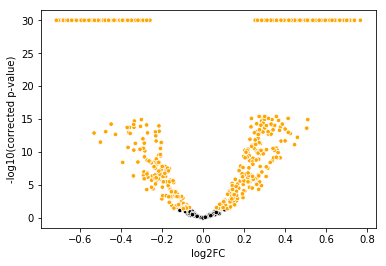

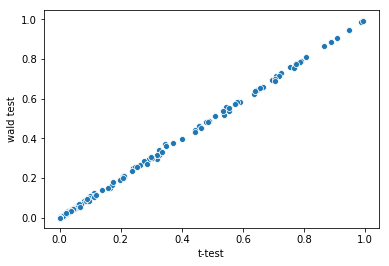

In [8]:
test.plot_diagnostics()